--- Creando objetos a partir del molde ---
[Bogotá] (Lat: 4.6097, Lon: -74.0817)
[Medellín] (Lat: 6.2442, Lon: -75.5812)
[Punto sin nombre] (Lat: 12.5847, Lon: -81.7006)

--- Usando los métodos del objeto ---
La distancia desde Bogotá hasta Medellín es: 246.14 km
O expresado en metros: 246135.99 m


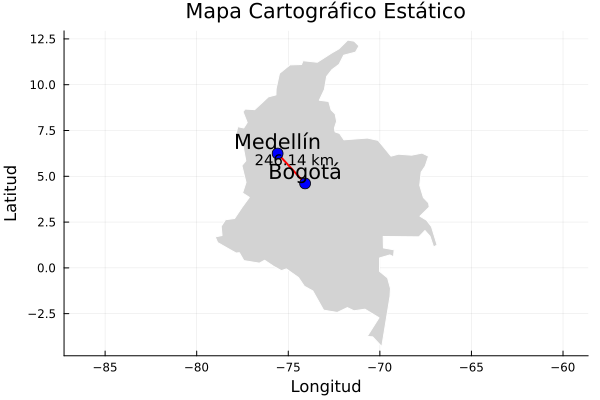

In [1]:
#| label: julia_clases_codigo
#| eval: false

using Printf
using Plots 

# --- 0. FUNCIÓN MATEMÁTICA DE APOYO ---
# Reutilizamos la fórmula del semiverseno (haversine) para el cálculo de distancias
function haversine(lat1, lon1, lat2, lon2; radio=6371.0)
    a = sin(deg2rad(lat2 - lat1) / 2)^2 + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * sin(deg2rad(lon2 - lon1) / 2)^2
    return radio * (2 * atan(sqrt(a), sqrt(1 - a)))
end


# --- 1. DEFINICIÓN DE LA CLASE (MOLDE) ---
# [1 📍] 1.1 EL CONSTRUCTOR (LA ESTRUCTURA)
# En Julia, la programación orientada a objetos se basa en 'structs' (estructuras).
# Aquí definimos las propiedades fundamentales que componen un punto espacial.
struct PuntoEspacial
    latitud::Float64   # Coordenada Y
    longitud::Float64  # Coordenada X
    nombre::String     # Etiqueta o nombre del lugar
end

# Definimos un método constructor adicional. Si el usuario no proporciona un nombre,
# el objeto se creará automáticamente con la etiqueta "Punto sin nombre".
PuntoEspacial(lat, lon) = PuntoEspacial(lat, lon, "Punto sin nombre")


# [2 💬] 1.2 LA REPRESENTACIÓN TEXTUAL
# Sobrescribimos la función 'show' de Julia. Esto nos permite controlar exactamente
# cómo se imprimirá nuestro objeto en la consola cuando usemos print().
function Base.show(io::IO, obj::PuntoEspacial)
    print(io, "[$(obj.nombre)] (Lat: $(obj.latitud), Lon: $(obj.longitud))")
end


# [3 📐] 1.3 MÉTODOS ANALÍTICOS (DESPACHO MÚLTIPLE)
# En lugar de encapsular la función dentro de la clase, en Julia pasamos el objeto
# explícitamente definiendo su tipo (::PuntoEspacial).
function distancia_hacia(origen::PuntoEspacial, destino::PuntoEspacial; radio=6371.0)
    distancia = haversine(origen.latitud, origen.longitud, destino.latitud, destino.longitud, radio=radio)
    return distancia
end


# [4 🗺️📐] 1.4 MÉTODO GRÁFICO (DIBUJO Y MANIPULACIÓN DE CADENAS)
# Este método enseña cómo leer datos espaciales crudos sin depender de librerías externas.
function graficar_ruta(origen::PuntoEspacial, destino::PuntoEspacial)
    
    # 1. Calculamos la distancia usando el método analítico del objeto
    dist = distancia_hacia(origen, destino)
    
    # 2. Preparamos vectores con las coordenadas para facilitar la gráfica
    lons = [origen.longitud, destino.longitud]
    lats = [origen.latitud, destino.latitud]
    nombres = [origen.nombre, destino.nombre]
    
    # Calculamos el punto medio para ubicar la etiqueta de la distancia
    mid_lon = (origen.longitud + destino.longitud) / 2
    mid_lat = (origen.latitud + destino.latitud) / 2
    
    # Preparamos el lienzo base
    mapa = plot(aspect_ratio=:equal, legend=false,
                xlabel="Longitud", ylabel="Latitud", title="Mapa Cartográfico Estático")
                
    # 3. Usamos un bloque try-catch para evitar que el programa falle si el archivo no existe
    try
        # Leemos el archivo GeoJSON como texto plano (String). 
        # Usamos Base.read explícitamente para evitar ambigüedades con otras funciones.
        texto_json = Base.read("./data/COL.geo.json", String)
        
        # Buscamos los delimitadores estructurales del arreglo de coordenadas en el JSON
        idx_inicio = findfirst("[[[", texto_json)
        idx_fin = findlast("]]]", texto_json)
        
        if idx_inicio !== nothing && idx_fin !== nothing
            # Aislamos únicamente el bloque de texto que contiene los números
            bloque = texto_json[last(idx_inicio)+1 : first(idx_fin)-1]
            puntos = split(bloque, "],[")
            
            xs = Float64[]
            ys = Float64[]
            
            # Iteramos sobre cada coordenada, limpiamos los caracteres extra y convertimos a número
            for pt in puntos
                limpio = replace(pt, "[" => "", "]" => "", " " => "")
                vals = split(limpio, ",")
                push!(xs, parse(Float64, vals[1]))
                push!(ys, parse(Float64, vals[2]))
            end
            
            # Dibujamos la geometría extraída (silueta del país)
            plot!(mapa, xs, ys, seriestype=:shape, fillcolor=:lightgrey, linecolor=:white)
        end
    catch e
        # Mensaje de respaldo si la lectura del mapa base falla
        annotate!(mapa, mid_lon, mid_lat + 1.5, text("(Sin mapa base)", :gray, 9))
    end
    
    # Trazamos la línea de la ruta que conecta los puntos
    plot!(mapa, lons, lats, linecolor=:red, linewidth=2)
    
    # Añadimos los marcadores de las ciudades
    scatter!(mapa, lons, lats, color=:blue, markersize=6, 
             series_annotations=text.(nombres, :bottom))
             
    # Insertamos el texto con el resultado de la distancia en el centro
    texto_distancia = " $(round(dist, digits=2)) km"
    annotate!(mapa, mid_lon, mid_lat, text(texto_distancia, :black, 10, :bottom))
             
    return mapa
end


# --- 2. CREACIÓN DE OBJETOS (INSTANCIACIÓN) ---

println("--- Creando objetos a partir del molde ---")

# [1 📍] INSTANCIACIÓN: Construyendo los objetos usando el 'struct'
punto_origen = PuntoEspacial(4.6097, -74.0817, "Bogotá")
punto_destino = PuntoEspacial(6.2442, -75.5812, "Medellín")
# Creamos un punto sin nombre para comprobar el comportamiento por defecto
punto_misterioso = PuntoEspacial(12.5847, -81.7006)

# [2 💬] REPRESENTACIÓN: Al imprimir, Julia aplica el formato definido en Base.show
println(punto_origen)
println(punto_destino)
println(punto_misterioso)

println("\n--- Usando los métodos del objeto ---")

# [3 📐] MÉTODOS ANALÍTICOS: Calculamos las distancias dinámicamente
resultado_km = distancia_hacia(punto_origen, punto_destino)
@printf("La distancia desde %s hasta %s es: %.2f km\n", punto_origen.nombre, punto_destino.nombre, resultado_km)

# Truco de conversión
resultado_metros = distancia_hacia(punto_origen, punto_destino, radio=6371000.0)
@printf("O expresado en metros: %.2f m\n", resultado_metros)

# [4 🗺️📐] MÉTODO GRÁFICO: Generamos y visualizamos el mapa
mapa_final = graficar_ruta(punto_origen, punto_destino)
mapa_final